### <b>Installation for the StyleGAN Encoder Network</b>

* Download the pixel2style2pixel (pSp) source code.

<pre>
!git clone https://github.com/eladrich/pixel2style2pixel.git pixel2style2pixel
</pre>

* Ninja is required to load c++ extensions in the pSp encoder.

<pre>
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
</pre>

* Download the pre-trained pSp model.

<pre>
import os

# Make a folder that contains pre-trained models
save_path = "./pretrained_models"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Download the pre-trained pSp model.
file_path = os.path.join(save_path, "psp_ffhq_encode.pt")
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EZDa4b7PITZCqrCcVVFrN4UBrFYkZmENV0uFQf1fE5gR5Q?download=1 -O $file_path
</pre>

* (Option) If the libcudart.so is not found, you may have to set environment variables.
    * Then, you may have to run the jupyter-notebook with "allow-root" option.

<pre>
# The example script:
export PATH=$PATH:/usr/local/cuda-10.0
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda-10.0/lib64
</pre>

* Download the face image alignment model.

<pre>
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
</pre>

* Download example images for the inversion.

<pre>
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ETkdz1PCJ_NAtj4NUdiQCVsBv2UpVamnhm-MUcD59NN-GA?download=1 -O inversion_images.zip
!unzip inversion_images.zip
</pre>

### <b>Installation for the Classification Network</b>

* Download the classification model.

<pre>
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EX15A0wm8MBLrBsT-9ARA-gBZ6W-RwmSw1IgYZzan4dELg?download=1 -O facial_identity_classification_using_transfer_learning_with_ResNet18_resolution_256_normalize_05.pth
</pre>

* Download the Celeb-HQ facial identity recognition dataset.

<pre>
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EcWlrJ2qjtRJtQVIwR1kW2EBTj8le3PdXI4TYsKErsGMcA?download=1 -O CelebA_HQ_facial_identity_dataset_test.zip
!unzip CelebA_HQ_facial_identity_dataset_test.zip -d ./CelebA_HQ_facial_identity_dataset_test
</pre>

### <b>Installation for Computing Metrics</b>

* Download the pre-trained CurricularFace model.

<pre>
import os

# Make a folder that contains pre-trained models
save_path = "./pretrained_models"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Download the pre-trained CurricularFace model.
file_path = os.path.join(save_path, "CurricularFace_Backbone.pth")
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eaaz-dJcRj1GspN39J3-5GkBbzkOZL6dvXD2MsVwOvwQsg?download=1 -O $file_path
</pre>

* Download the pre-trained MTCNN model.

<pre>
import os

# Make a folder that contains pre-trained models
save_path = "./pretrained_models"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Download the pre-trained MTCNN model.
file_path = os.path.join(save_path, "mtcnn.tar.gz")
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EdSEMj6JF7VEpXo296X6fekB0uvcyMRH8LkUj15VafAuJA?download=1 -O $file_path
!tar -zxvf $file_path -C $save_path
</pre>

### <b>Load the pSp Network</b>

* Load the required libraries.

In [1]:
from argparse import Namespace
import time
import sys
import pprint
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms

sys.path.append("./pixel2style2pixel")

import dlib
from scripts.align_all_parallel import align_face
from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# reproducible source code
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

* Load the pre-trained pSp (encoder) model.

In [2]:
model_path = "./pretrained_models/psp_ffhq_encode.pt"
ckpt = torch.load(model_path, map_location='cpu')

# load the hyper-parameters
opts = ckpt['opts']

# update the training options
opts['checkpoint_path'] = model_path
if 'learn_in_w' not in opts:
    opts['learn_in_w'] = False
if 'output_size' not in opts:
    opts['output_size'] = 1024

# show the hyper-parameters
pprint.pprint(opts)

# load the pre-trained model
net = pSp(Namespace(**opts))
net.eval()
net.cuda()
print('Model successfully loaded!')

{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': './pretrained_models/psp_ffhq_encode.pt',
 'dataset_type': 'ffhq_encode',
 'device': 'cuda:0',
 'encoder_type': 'GradualStyleEncoder',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 3,
 'l2_lambda': 1.0,
 'l2_lambda_crop': 0,
 'label_nc': 0,
 'learn_in_w': False,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.8,
 'lpips_lambda_crop': 0,
 'max_steps': 300000,
 'optim_name': 'ranger',
 'output_size': 1024,
 'resize_factors': None,
 'save_interval': 1000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 2,
 'train_decoder': False,
 'val_interval': 2500,
 'w_norm_lambda': 0,
 'workers': 8}
Loading pSp from checkpoint: ./pretrained_models/psp_ffhq_encode.pt
Model successfully loaded!


* Encode an example image.

Aligned image has shape: (256, 256)


/home/dongbin/mine/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Inference took 0.3761 seconds.


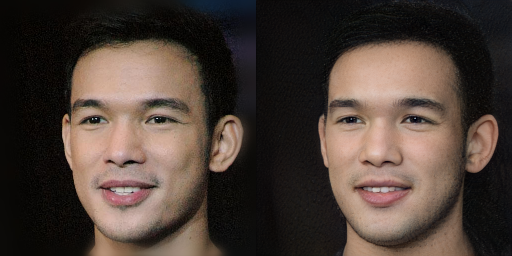

In [3]:
def run_alignment(image_path):
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor)
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image


img_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

image_path = "./pixel2style2pixel/notebooks/images/input_img.jpg"
input_image = run_alignment(image_path)
input_image.resize((256, 256))
transformed_image = img_transforms(input_image)
inputs = transformed_image.unsqueeze(0).cuda().float()

# inference
with torch.no_grad():
    tic = time.time()

    # get latent codes
    codes = net.encoder(inputs)
    
    # normalize with respect to the center of an average face
    codes = codes + net.latent_avg.repeat(codes.shape[0], 1, 1)

    # get output face image using latent codes
    result_images, result_latent = net.decoder([codes], input_is_latent=True, randomize_noise=False, return_latents=False)

    # resize the output image into 256 X 256
    result_images = net.face_pool(result_images)

    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

# visualize the result
input_vis_image = tensor2im(inputs[0]) # original image
output_image = tensor2im(result_images[0]) # inverted image

# concatenate the two images
res = np.concatenate([np.array(input_vis_image.resize((256, 256))),
                      np.array(output_image.resize((256, 256)))], axis=1)
res_image = Image.fromarray(res)
res_image

* Encode multiple images.

/home/dongbin/mine/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


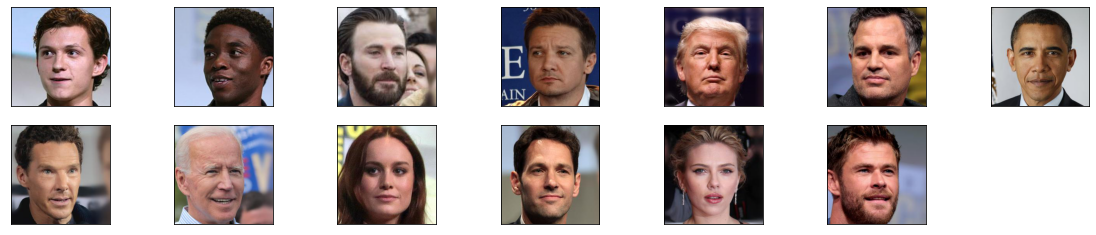

In [4]:
%matplotlib inline

save_path = "./inversion_images"
image_paths = [os.path.join(save_path, f) for f in os.listdir(save_path) if f.endswith(".jpg")]
n_images = len(image_paths)

images = []
n_cols = np.ceil(n_images / 2)
fig = plt.figure(figsize=(20, 4))
for idx, image_path in enumerate(image_paths):
    ax = fig.add_subplot(2, n_cols, idx + 1)
    img = Image.open(image_path).convert("RGB")
    images.append(img)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img)
plt.show()

torch.Size([13, 3, 256, 256])
Inference took 0.9568 seconds.


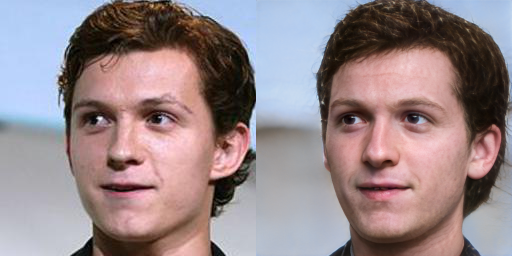

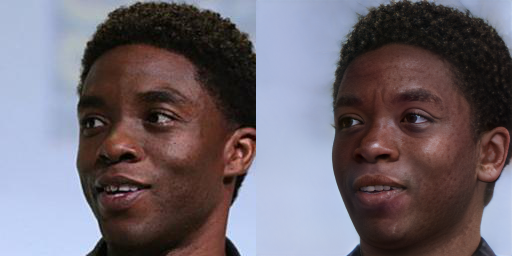

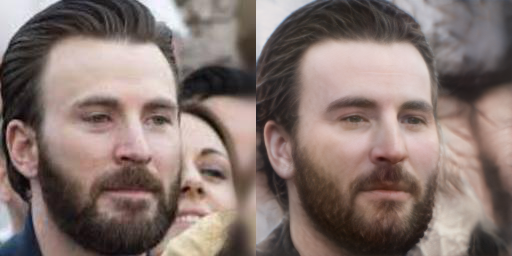

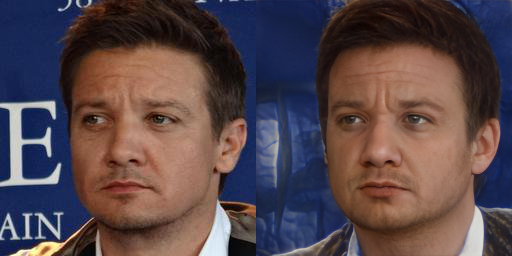

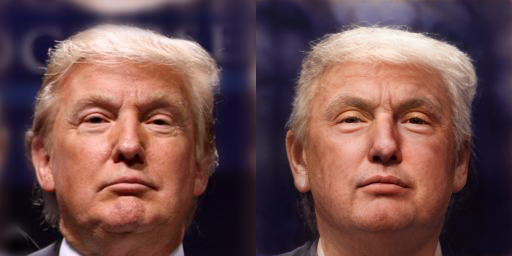

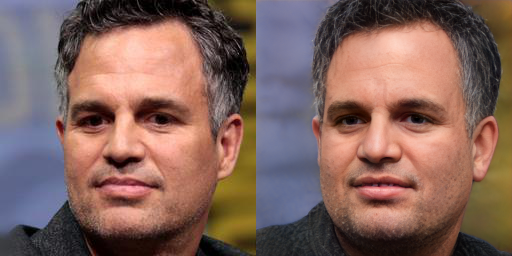

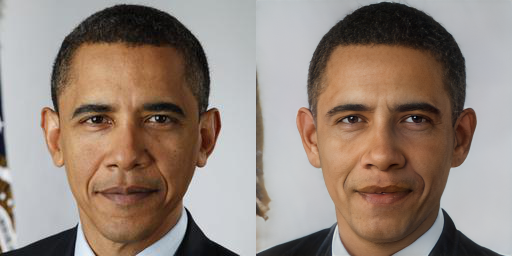

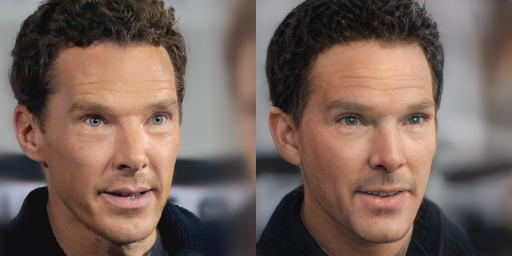

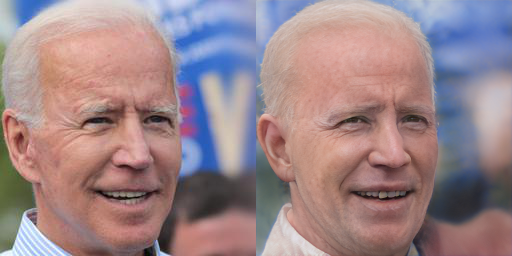

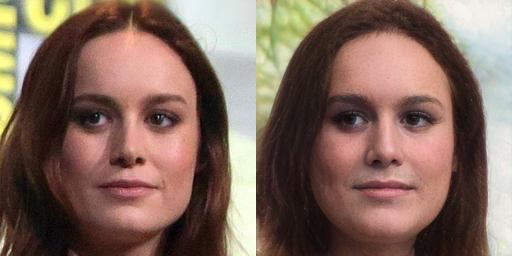

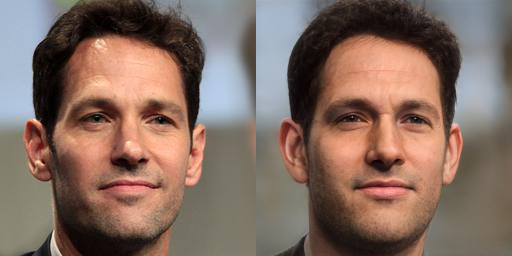

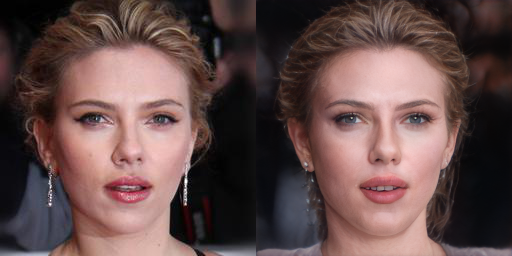

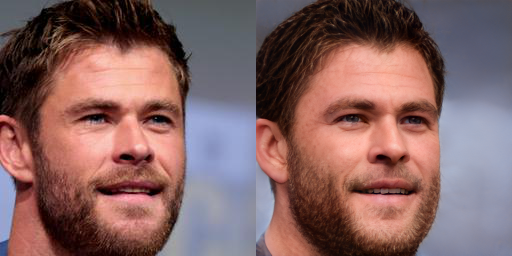

In [5]:
transformed_images = [img_transforms(image) for image in images]
batched_images = torch.stack(transformed_images, dim=0).cuda().float()
print(batched_images.shape)

with torch.no_grad():
    tic = time.time()

    # get latent codes
    codes = net.encoder(batched_images)

    # normalize with respect to the center of an average face
    codes = codes + net.latent_avg.repeat(codes.shape[0], 1, 1)

    # get output face image using latent codes
    result_images, result_latent = net.decoder([codes], input_is_latent=True, randomize_noise=False, return_latents=False)

    # resize the output image into 256 X 256
    result_images = net.face_pool(result_images)

    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

couple_results = []
for original_image, result_image in zip(images, result_images):
    result_image = tensor2im(result_image)
    res = np.concatenate([np.array(original_image.resize((256, 256))),
                          np.array(result_image.resize((256, 256)))], axis=1)
    res_im = Image.fromarray(res)
    couple_results.append(res_im)
    display(res_im)

In [6]:
def normalize_to_normal_image(image):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(-1, 3, 1, 1).float()
    std = torch.tensor([0.5, 0.5, 0.5]).view(-1, 3, 1, 1).float()
    
    image = image.detach().cpu()
    image *= std
    image += mean
    image[image < 0] = 0
    image[image > 1] = 1
    image *= 255
    
    image = image.numpy()
    image = np.transpose(image, (0, 2, 3, 1))

    return image.astype(np.uint8)


data_dir = './CelebA_HQ_facial_identity_dataset_test/'

test_dataset = datasets.ImageFolder(os.path.join(data_dir), img_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)
print('Test dataset size:', len(test_dataset))

class_names = test_dataset.classes
print('Class names:', class_names)

Test dataset size: 1215
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '223', '226', '228', '230', 

[Inputs]
torch.Size([5, 3, 256, 256])
(5, 256, 256, 3)
Inference took 0.4762 seconds.
[Outputs]
torch.Size([5, 3, 256, 256])
(5, 256, 256, 3)


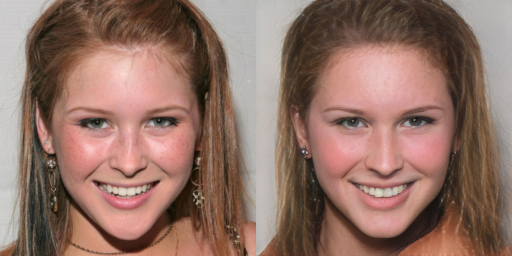

In [7]:
# get normal images
start_index = 100
num_test_images = 5
inputs = torch.cat([test_dataset[i][0].unsqueeze(0).cuda() for i in range(start_index, start_index + num_test_images)], dim=0)
normal_images = normalize_to_normal_image(inputs)
print('[Inputs]')
print(inputs.shape)
print(normal_images.shape)

# inference
with torch.no_grad():
    tic = time.time()

    # get latent codes
    codes = net.encoder(inputs)
    
    # normalize with respect to the center of an average face
    codes = codes + net.latent_avg.repeat(codes.shape[0], 1, 1)

    # get output face image using latent codes
    result_images, result_latent = net.decoder([codes], input_is_latent=True, randomize_noise=False, return_latents=False)

    # resize the output image into 256 X 256
    result_images = net.face_pool(result_images)

    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

output_images = normalize_to_normal_image(result_images)
print('[Outputs]')
print(result_images.shape)
print(output_images.shape)

# visualize the result
input_vis_image = tensor2im(inputs[0]) # original image
output_image = tensor2im(result_images[0]) # inverted image

# concatenate the two images
res = np.concatenate([np.array(input_vis_image.resize((256, 256))),
                      np.array(output_image.resize((256, 256)))], axis=1)
res_image = Image.fromarray(res)
res_image

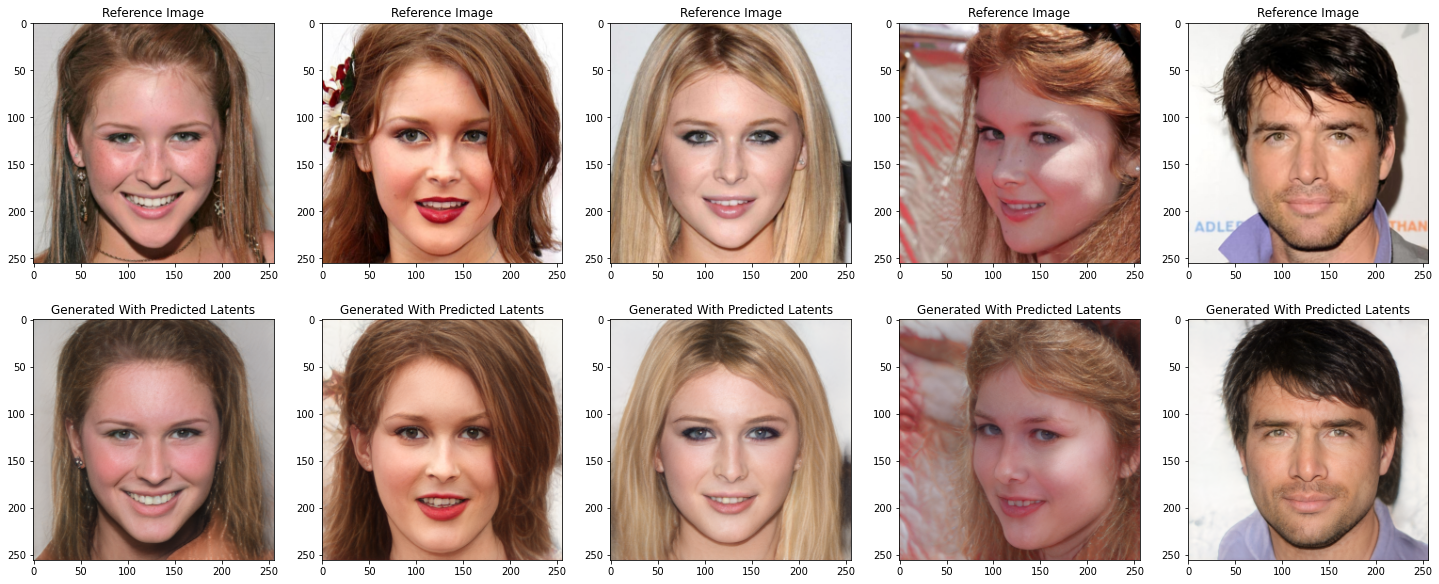

In [8]:
figure = plt.figure(figsize=(25, 10))

columns = len(normal_images)
rows = 2

axis = []
for i in range(columns):
    axis.append(figure.add_subplot(rows, columns, i + 1))
    axis[-1].set_title("Reference Image")
    plt.imshow(normal_images[i])
for i in range(columns, columns * rows):
    axis.append(figure.add_subplot(rows, columns, i + 1))
    axis[-1].set_title("Generated With Predicted Latents")
    plt.imshow(output_images[i - columns])

plt.show()

### <b>Load the Classification Network</b>

* Load the classification model.

In [9]:
save_path = 'facial_identity_classification_using_transfer_learning_with_ResNet18_resolution_256_normalize_05.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
model.load_state_dict(torch.load(save_path))
model.cuda()

print('The classification model successfully loaded!')

The classification model successfully loaded!


In [10]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

[Prediction Result Examples]


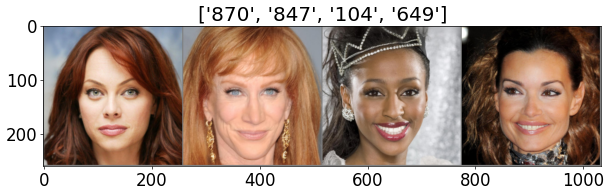

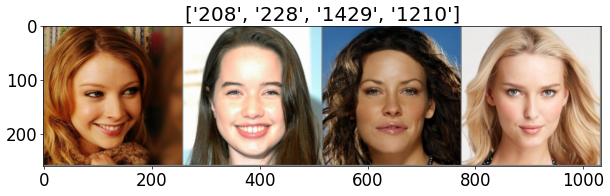

[Test] Loss: 0.5161 Acc: 87.8189% Time: 8.1038s


In [11]:
criterion = nn.CrossEntropyLoss()
model.eval()

start_time = time.time()
with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

### <b>Test the Label Consistency</b>

* Load the pre-trained networks for computing metrics.
    * Reference: https://github.com/eladrich/pixel2style2pixel

In [12]:
from models.mtcnn.mtcnn import MTCNN
from models.encoders.model_irse import IR_101
from configs.paths_config import model_paths
from criteria.lpips.lpips import LPIPS


# Facial similarity score
facenet = IR_101(input_size=112)
facenet.load_state_dict(torch.load("./pretrained_models/CurricularFace_Backbone.pth"))
facenet.cuda()
facenet.eval()
mtcnn = MTCNN()

# LPIPS loss
lpips_loss = LPIPS(net_type='alex')

cuda:0


[Original Image Examples]


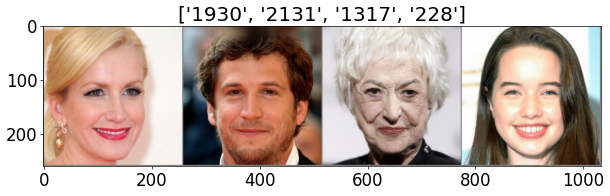

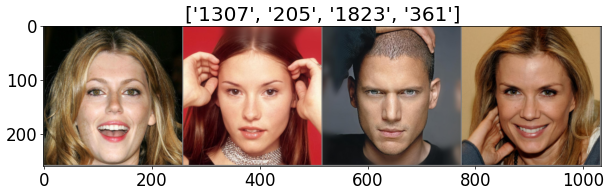

[Original Prediction Result Examples]


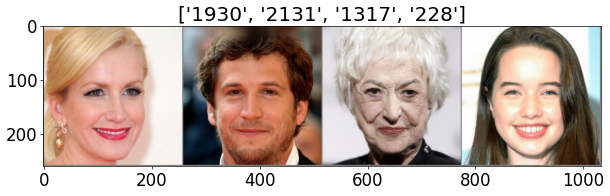

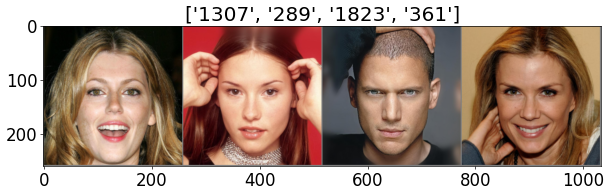

[Encoded Prediction Result Examples]


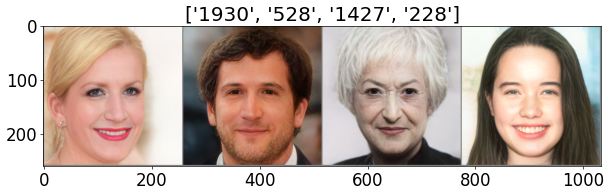

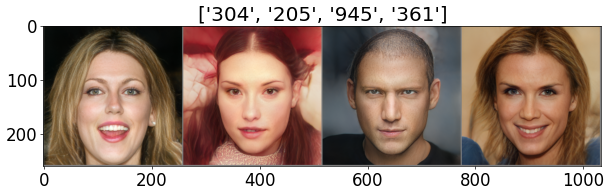

[Test] Average similarity score: 0.6465 Average LPIPS loss: 0.1504 Original accuracy: 87.8189% Encoded accuracy: 69.0535% Consistency accuracy: 70.7819% Correctly consistency accuracy: 66.9959% Time: 113.6284s


In [13]:
criterion = nn.CrossEntropyLoss()
model.eval()

start_time = time.time()
with torch.no_grad():
    similarity_scores = 0
    lpips_losses = 0
    ori_running_corrects = 0
    encoded_running_corrects = 0
    consistency = 0
    correctly_consistency = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)
        _, ori_preds = torch.max(outputs, 1)

        # get predicted latents
        codes = net.encoder(inputs)
        codes = codes + net.latent_avg.repeat(codes.shape[0], 1, 1)

        # get predicted images and resize the output image into 256 X 256
        pred_images, result_latent = net.decoder([codes], input_is_latent=True, randomize_noise=False, return_latents=False)
        pred_images = net.face_pool(pred_images)

        outputs = model(pred_images)
        _, encoded_preds = torch.max(outputs, 1)
        
        # for similarity scores
        input_id = facenet(inputs)
        result_id = facenet(pred_images)
        
        similarity_scores += torch.sum(torch.bmm(input_id.unsqueeze(1), result_id.unsqueeze(2))) # dot products
        lpips_losses += lpips_loss(inputs, pred_images) * inputs.shape[0] # LPIPS loss
        ori_running_corrects += torch.sum(ori_preds == labels.data)
        encoded_running_corrects += torch.sum(encoded_preds == labels.data)
        consistency += torch.sum(ori_preds == encoded_preds)
        correctly_consistency += torch.sum(torch.logical_and(ori_preds == encoded_preds, encoded_preds == labels.data))
        
        if i == 0:
            print('[Original Image Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            print('[Original Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in ori_preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in ori_preds[4:8]])
            print('[Encoded Prediction Result Examples]')
            images = torchvision.utils.make_grid(pred_images[:4])
            imshow(images.cpu(), title=[class_names[x] for x in encoded_preds[:4]])
            images = torchvision.utils.make_grid(pred_images[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in encoded_preds[4:8]])

    average_similarity_score = similarity_scores / len(test_dataset)
    average_lpips_loss = lpips_losses / len(test_dataset)
    ori_epoch_acc = ori_running_corrects / len(test_dataset) * 100.
    encoded_epoch_acc = encoded_running_corrects / len(test_dataset) * 100.
    consistency_epoch_acc = consistency / len(test_dataset) * 100.
    correctly_consistency_epoch_acc = correctly_consistency / len(test_dataset) * 100.

    print('[Test] Average similarity score: {:.4f} Average LPIPS loss: {:.4f} Original accuracy: {:.4f}% Encoded accuracy: {:.4f}% Consistency accuracy: {:.4f}% Correctly consistency accuracy: {:.4f}% Time: {:.4f}s'.format(average_similarity_score, average_lpips_loss, ori_epoch_acc, encoded_epoch_acc, consistency_epoch_acc, correctly_consistency_epoch_acc, time.time() - start_time))

### <b>Generate a New Dataset</b>

In [17]:
from torchvision.utils import save_image

root_path = './output/'


def make_classes(labels):
    for i in range(labels.shape[0]):
        label_name = class_names[labels[i]]
        if not os.path.exists(root_path + label_name):
            os.makedirs(root_path + label_name)


def save_images(images, labels):
    for i in range(images.shape[0]):
        image = images[i]
        label_name = class_names[labels[i]]

        if not os.path.exists(root_path + label_name):
            os.makedirs(root_path + label_name)

        cnt = len(os.listdir(root_path + label_name))
        save_image(image, f'{root_path + label_name}/img{cnt}.png')


def unnormalize(image):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(-1, 3, 1, 1).float()
    std = torch.tensor([0.5, 0.5, 0.5]).view(-1, 3, 1, 1).float()
    
    image = image.detach().cpu()
    image *= std
    image += mean
    image[image < 0] = 0
    image[image > 1] = 1

    return image

[Original Image Examples]


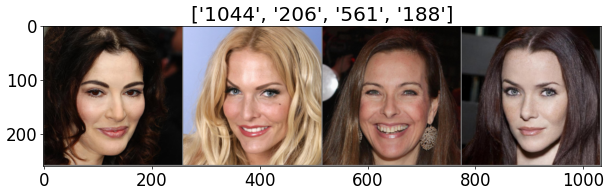

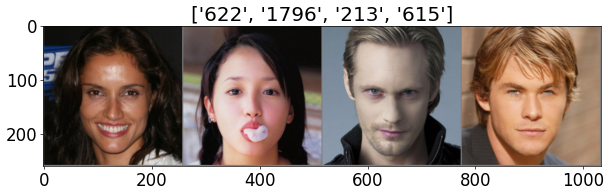

[Original Prediction Result Examples]


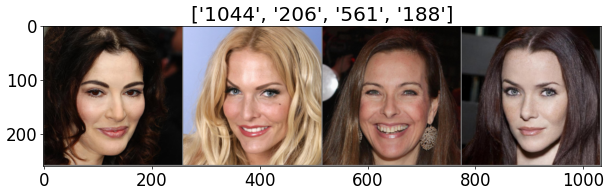

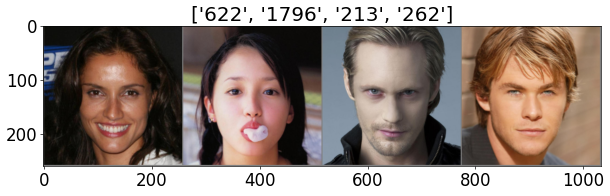

[Encoded Prediction Result Examples]


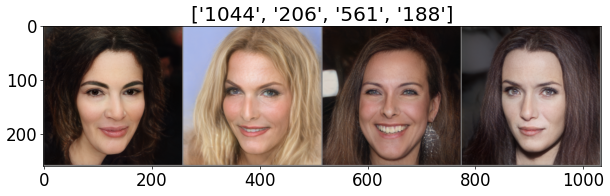

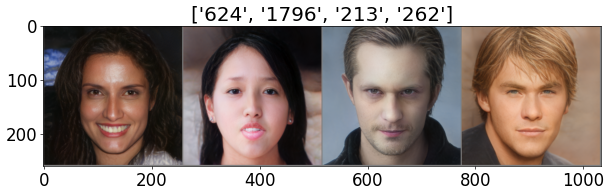

[Test] Average similarity score: 0.6465 Average LPIPS loss: 0.1504 Original accuracy: 87.8189% Encoded accuracy: 69.0535% Consistency accuracy: 70.7819% Correctly consistency accuracy: 66.9959% Time: 160.5752s


In [18]:
criterion = nn.CrossEntropyLoss()
model.eval()

start_time = time.time()
with torch.no_grad():
    similarity_scores = 0
    lpips_losses = 0
    ori_running_corrects = 0
    encoded_running_corrects = 0
    consistency = 0
    correctly_consistency = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)
        _, ori_preds = torch.max(outputs, 1)

        # get predicted latents
        codes = net.encoder(inputs)
        codes = codes + net.latent_avg.repeat(codes.shape[0], 1, 1)

        # get predicted images and resize the output image into 256 X 256
        pred_images, result_latent = net.decoder([codes], input_is_latent=True, randomize_noise=False, return_latents=False)
        pred_images = net.face_pool(pred_images)

        outputs = model(pred_images)
        _, encoded_preds = torch.max(outputs, 1)
        
        # for similarity scores
        input_id = facenet(inputs)
        result_id = facenet(pred_images)
        
        similarity_scores += torch.sum(torch.bmm(input_id.unsqueeze(1), result_id.unsqueeze(2))) # dot products
        lpips_losses += lpips_loss(inputs, pred_images) * inputs.shape[0] # LPIPS loss
        ori_running_corrects += torch.sum(ori_preds == labels.data)
        encoded_running_corrects += torch.sum(encoded_preds == labels.data)
        consistency += torch.sum(ori_preds == encoded_preds)
        correctly_consistency += torch.sum(torch.logical_and(ori_preds == encoded_preds, encoded_preds == labels.data))

        current_images = inputs[torch.logical_and(ori_preds == encoded_preds, encoded_preds == labels.data)]
        current_labels = labels[torch.logical_and(ori_preds == encoded_preds, encoded_preds == labels.data)]
        current_images = unnormalize(current_images)
        
        make_classes(labels)
        save_images(current_images, current_labels)

        if i == 0:
            print('[Original Image Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            print('[Original Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in ori_preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in ori_preds[4:8]])
            print('[Encoded Prediction Result Examples]')
            images = torchvision.utils.make_grid(pred_images[:4])
            imshow(images.cpu(), title=[class_names[x] for x in encoded_preds[:4]])
            images = torchvision.utils.make_grid(pred_images[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in encoded_preds[4:8]])

    average_similarity_score = similarity_scores / len(test_dataset)
    average_lpips_loss = lpips_losses / len(test_dataset)
    ori_epoch_acc = ori_running_corrects / len(test_dataset) * 100.
    encoded_epoch_acc = encoded_running_corrects / len(test_dataset) * 100.
    consistency_epoch_acc = consistency / len(test_dataset) * 100.
    correctly_consistency_epoch_acc = correctly_consistency / len(test_dataset) * 100.

    print('[Test] Average similarity score: {:.4f} Average LPIPS loss: {:.4f} Original accuracy: {:.4f}% Encoded accuracy: {:.4f}% Consistency accuracy: {:.4f}% Correctly consistency accuracy: {:.4f}% Time: {:.4f}s'.format(average_similarity_score, average_lpips_loss, ori_epoch_acc, encoded_epoch_acc, consistency_epoch_acc, correctly_consistency_epoch_acc, time.time() - start_time))

### <b>Final Test Using Generated Dataset</b>

In [19]:
# ref: https://chsasank.github.io/vision/_modules/torchvision/datasets/folder.html
from PIL import Image
import os
import os.path
from torch.utils.data import Dataset

EXTENSIONS = [
    '.png',
]


def is_png_file(filename):
    return any(filename.endswith(extension) for extension in EXTENSIONS)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(dir, class_to_idx):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_png_file(fname):
                    path = os.path.join(root, fname).split('.png')[0]
                    item = (path + '.png', class_to_idx[target])
                    images.append(item)

    return images


def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


class CustomFolder(Dataset):
    def __init__(self, root, target_transforms):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root, class_to_idx)

        self.root = root
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.pil_loader = pil_loader
        self.target_transforms = target_transforms

    def __getitem__(self, index):
        img, target = self.imgs[index]
        img = self.pil_loader(img)
        img = self.target_transforms(img)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [20]:
data_dir = './output/'

final_test_dataset = CustomFolder(os.path.join(data_dir), img_transforms)
final_test_dataloader = torch.utils.data.DataLoader(final_test_dataset, batch_size=16, shuffle=True, num_workers=4)
print('Test dataset size:', len(final_test_dataset))

class_names = final_test_dataset.classes
print('Class names:', class_names)

Test dataset size: 814
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '223', '226', '228', '230', '

[Original Image Examples]


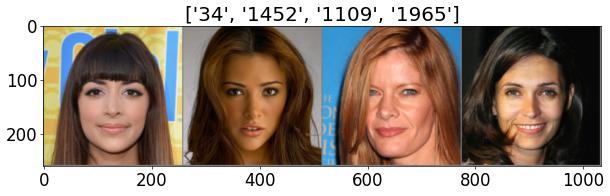

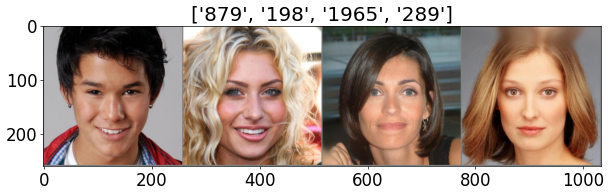

[Original Prediction Result Examples]


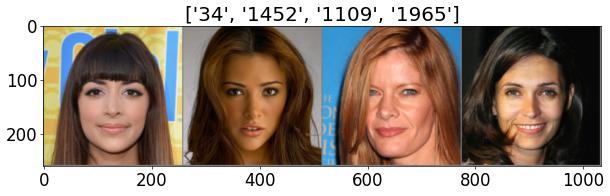

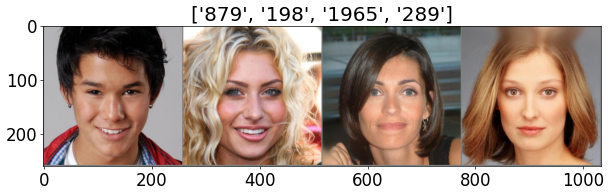

[Encoded Prediction Result Examples]


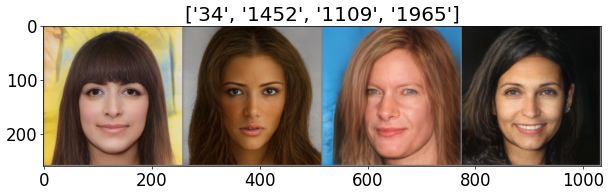

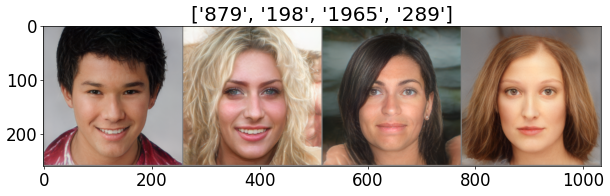

[Test] Average similarity score: 0.6514 Average LPIPS loss: 0.1444 Original accuracy: 100.0000% Encoded accuracy: 100.0000% Consistency accuracy: 100.0000% Correctly consistency accuracy: 100.0000% Time: 76.5793s


In [21]:
criterion = nn.CrossEntropyLoss()
model.eval()

start_time = time.time()
with torch.no_grad():
    similarity_scores = 0
    lpips_losses = 0
    ori_running_corrects = 0
    encoded_running_corrects = 0
    consistency = 0
    correctly_consistency = 0

    for i, (inputs, labels) in enumerate(final_test_dataloader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        outputs = model(inputs)
        _, ori_preds = torch.max(outputs, 1)

        # get predicted latents
        codes = net.encoder(inputs)
        codes = codes + net.latent_avg.repeat(codes.shape[0], 1, 1)

        # get predicted images and resize the output image into 256 X 256
        pred_images, result_latent = net.decoder([codes], input_is_latent=True, randomize_noise=False, return_latents=False)
        pred_images = net.face_pool(pred_images)

        outputs = model(pred_images)
        _, encoded_preds = torch.max(outputs, 1)
        
        # for similarity scores
        input_id = facenet(inputs)
        result_id = facenet(pred_images)
        
        similarity_scores += torch.sum(torch.bmm(input_id.unsqueeze(1), result_id.unsqueeze(2))) # dot products
        lpips_losses += lpips_loss(inputs, pred_images) * inputs.shape[0] # LPIPS loss
        ori_running_corrects += torch.sum(ori_preds == labels.data)
        encoded_running_corrects += torch.sum(encoded_preds == labels.data)
        consistency += torch.sum(ori_preds == encoded_preds)
        correctly_consistency += torch.sum(torch.logical_and(ori_preds == encoded_preds, encoded_preds == labels.data))
        
        if i == 0:
            print('[Original Image Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            print('[Original Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in ori_preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in ori_preds[4:8]])
            print('[Encoded Prediction Result Examples]')
            images = torchvision.utils.make_grid(pred_images[:4])
            imshow(images.cpu(), title=[class_names[x] for x in encoded_preds[:4]])
            images = torchvision.utils.make_grid(pred_images[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in encoded_preds[4:8]])

    average_similarity_score = similarity_scores / len(final_test_dataset)
    average_lpips_loss = lpips_losses / len(final_test_dataset)
    ori_epoch_acc = ori_running_corrects / len(final_test_dataset) * 100.
    encoded_epoch_acc = encoded_running_corrects / len(final_test_dataset) * 100.
    consistency_epoch_acc = consistency / len(final_test_dataset) * 100.
    correctly_consistency_epoch_acc = correctly_consistency / len(final_test_dataset) * 100.

    print('[Test] Average similarity score: {:.4f} Average LPIPS loss: {:.4f} Original accuracy: {:.4f}% Encoded accuracy: {:.4f}% Consistency accuracy: {:.4f}% Correctly consistency accuracy: {:.4f}% Time: {:.4f}s'.format(average_similarity_score, average_lpips_loss, ori_epoch_acc, encoded_epoch_acc, consistency_epoch_acc, correctly_consistency_epoch_acc, time.time() - start_time))

In [22]:
!mv ./output/ ./corrected_facial_identity_images_ResNet18/
!zip -r corrected_facial_identity_images_ResNet18.zip ./corrected_facial_identity_images_ResNet18/*

  adding: corrected_facial_identity_images_ResNet18/102/ (stored 0%)
  adding: corrected_facial_identity_images_ResNet18/102/img1.png (deflated 0%)
  adding: corrected_facial_identity_images_ResNet18/102/img0.png (deflated 0%)
  adding: corrected_facial_identity_images_ResNet18/1027/ (stored 0%)
  adding: corrected_facial_identity_images_ResNet18/1027/img2.png (deflated 0%)
  adding: corrected_facial_identity_images_ResNet18/1027/img1.png (deflated 0%)
  adding: corrected_facial_identity_images_ResNet18/1027/img0.png (deflated 0%)
  adding: corrected_facial_identity_images_ResNet18/103/ (stored 0%)
  adding: corrected_facial_identity_images_ResNet18/103/img2.png (deflated 0%)
  adding: corrected_facial_identity_images_ResNet18/103/img3.png (deflated 0%)
  adding: corrected_facial_identity_images_ResNet18/103/img1.png (deflated 0%)
  adding: corrected_facial_identity_images_ResNet18/103/img0.png (deflated 0%)
  adding: corrected_facial_identity_images_ResNet18/104/ (stored 0%)
  adding: